### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID Detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COVID Detection


### Import all dependencies

In [2]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [15]:

#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 50
batch_size = 8

#define paths
covid_path = '/content/drive/MyDrive/COVID Detection/CT_COVID'
noncovid_path = '/content/drive/MyDrive/COVID Detection/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [16]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['/content/drive/MyDrive/COVID Detection/CT_COVID/Covid (89).png', '/content/drive/MyDrive/COVID Detection/CT_COVID/Covid (95).png', '/content/drive/MyDrive/COVID Detection/CT_COVID/Covid (9).png', '/content/drive/MyDrive/COVID Detection/CT_COVID/Covid (96).png', '/content/drive/MyDrive/COVID Detection/CT_COVID/Covid (92).png']
Total Count:  500
First 5 NonCovid Files:  ['/content/drive/MyDrive/COVID Detection/CT_NonCOVID/Non-Covid (94).png', '/content/drive/MyDrive/COVID Detection/CT_NonCOVID/Non-Covid (93).png', '/content/drive/MyDrive/COVID Detection/CT_NonCOVID/Non-Covid (96).png', '/content/drive/MyDrive/COVID Detection/CT_NonCOVID/Non-Covid (89).png', '/content/drive/MyDrive/COVID Detection/CT_NonCOVID/Non-Covid (9).png']
Total Count:  499


### Fetch Images and Class Labels from Files (This might take a while)

In [17]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

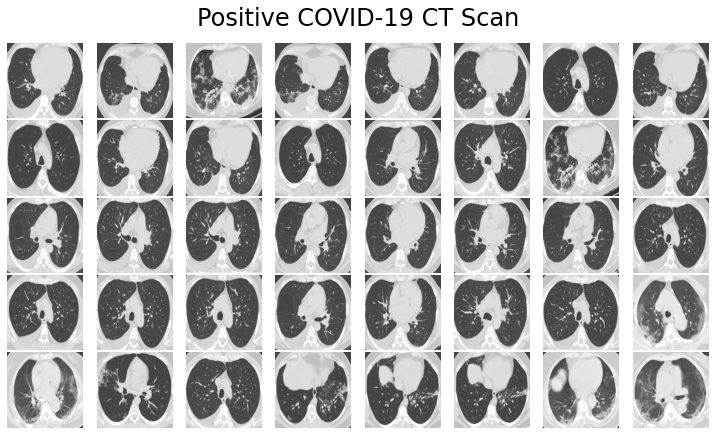

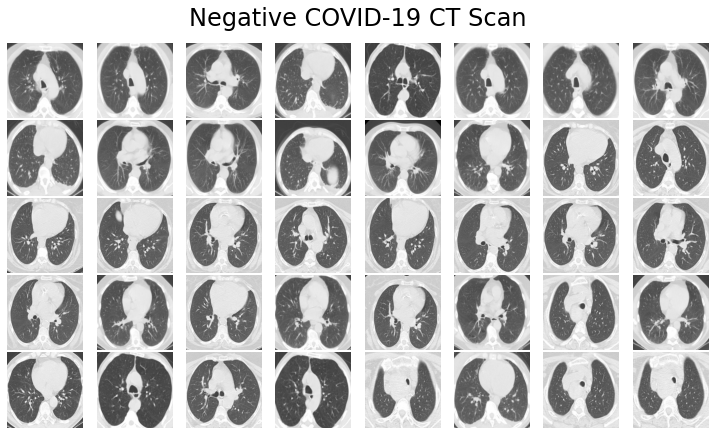

In [18]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [19]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [20]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

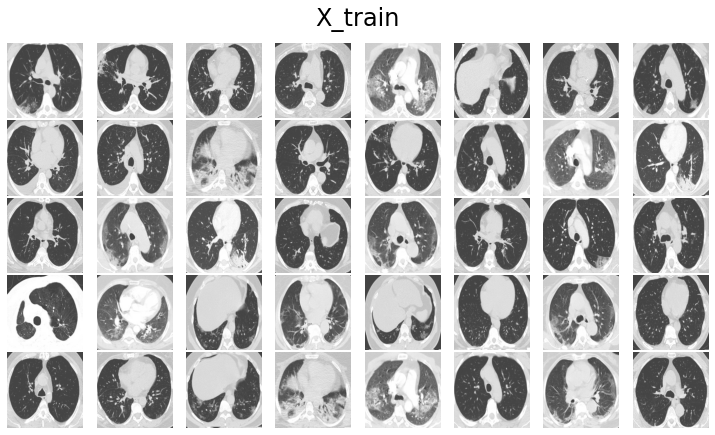

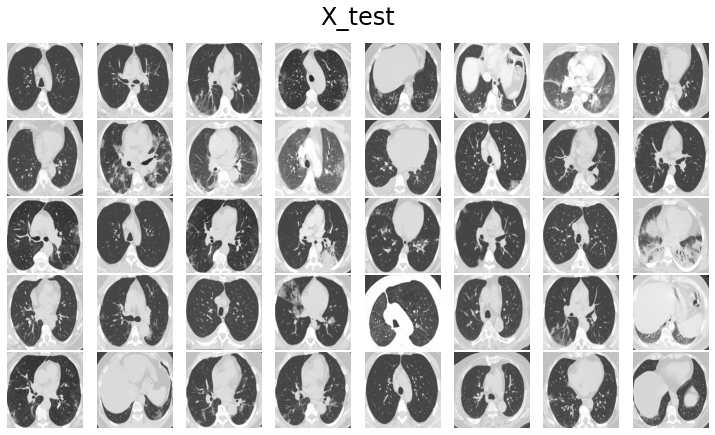

In [21]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [22]:
# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="sigmoid")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = True

model.compile(
        loss='binary_crossentropy',                                               #'categorical_crossentropy' used for sofmax, 
        optimizer='adam', 
        metrics=['accuracy']
)

In [23]:
# Visualize Model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [24]:
train_aug = ImageDataGenerator(rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True
)

### **Training the model**

In [42]:
hist = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                  validation_data=(X_test, y_test),
                validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs) 

Epoch 1/50
99/99 [==============================] - 13s 128ms/step - loss: 0.8202 - accuracy: 0.8936 - val_loss: 0.1532 - val_accuracy: 0.9300
Epoch 2/50
99/99 [==============================] - 14s 137ms/step - loss: 0.2188 - accuracy: 0.9287 - val_loss: 0.1672 - val_accuracy: 0.9250
Epoch 3/50
99/99 [==============================] - 13s 127ms/step - loss: 0.3713 - accuracy: 0.9287 - val_loss: 0.1786 - val_accuracy: 0.9450
Epoch 4/50
99/99 [==============================] - 13s 127ms/step - loss: 0.2612 - accuracy: 0.9161 - val_loss: 1.7344 - val_accuracy: 0.6200
Epoch 5/50
99/99 [==============================] - 13s 126ms/step - loss: 0.2678 - accuracy: 0.9299 - val_loss: 19.8750 - val_accuracy: 0.5650
Epoch 6/50
99/99 [==============================] - 13s 126ms/step - loss: 0.2017 - accuracy: 0.9412 - val_loss: 0.4280 - val_accuracy: 0.9200
Epoch 7/50
99/99 [==============================] - 13s 126ms/step - loss: 0.1637 - accuracy: 0.9487 - val_loss: 0.0537 - val_accuracy: 0.990

In [43]:
##callback = EarlyStopping(monitor='val_loss', patience=50)

In [44]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.10, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [27]:
##history = model.fit(X_train, y_train,epochs=5)

Epoch 1/5
25/25 [==============================] - 10s 343ms/step - loss: 0.4437 - accuracy: 0.9224
Epoch 2/5
25/25 [==============================] - 9s 346ms/step - loss: 0.4558 - accuracy: 0.9549
Epoch 3/5
25/25 [==============================] - 9s 350ms/step - loss: 0.3369 - accuracy: 0.9562
Epoch 4/5
25/25 [==============================] - 9s 353ms/step - loss: 0.1969 - accuracy: 0.9462
Epoch 5/5
25/25 [==============================] - 9s 349ms/step - loss: 0.1389 - accuracy: 0.9625


In [45]:
import os



In [46]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [47]:
# Load saved model
model = load_model('resnet_ct.h5')
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

7/7 [==============================] - 2s 91ms/step - loss: 0.1350 - accuracy: 0.9850
Final Loss: 0.1350357085466385, Final Accuracy: 0.9850000143051147


### **Making Predicions**

In [48]:
y_pred = model.predict(X_test, batch_size=batch_size)

25/25 [==============================] - 2s 33ms/step


### Visulaizing First 10 predictions

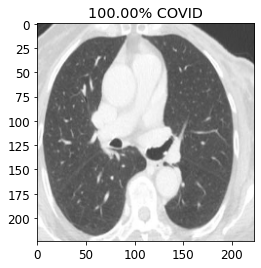

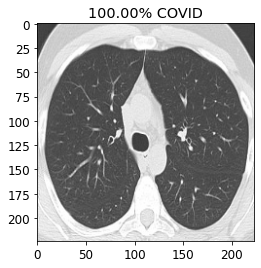

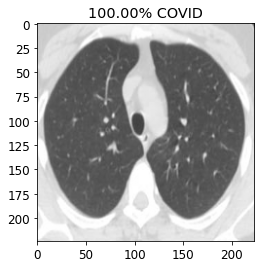

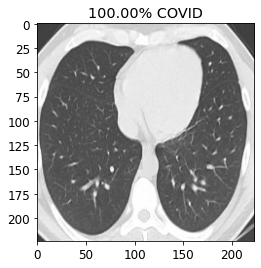

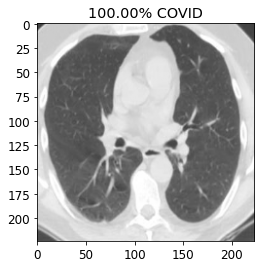

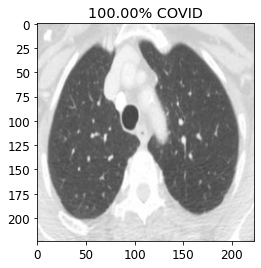

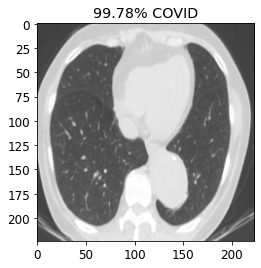

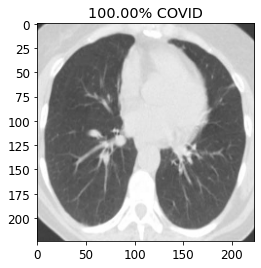

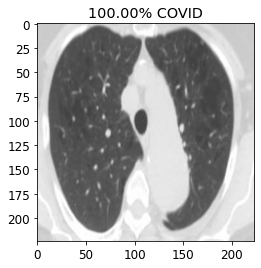

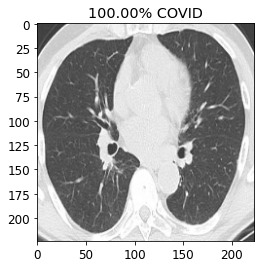

In [49]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [50]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

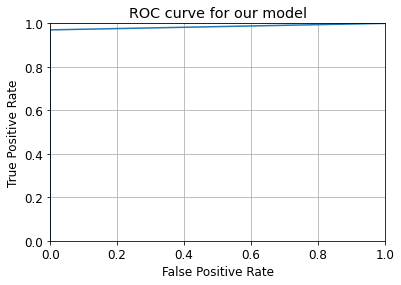

In [51]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


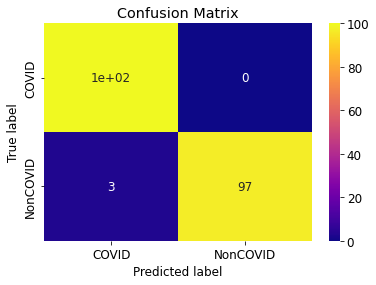

Confusion Matrix with Normalized Values


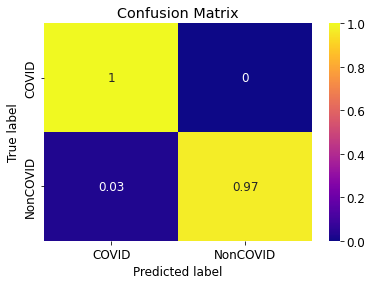

In [52]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



### **Accuracy and Loss Plots**

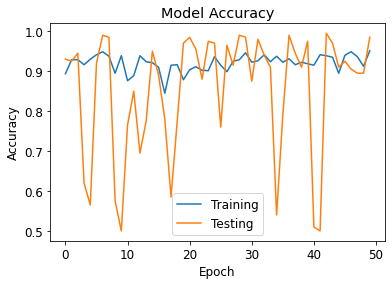

In [54]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()


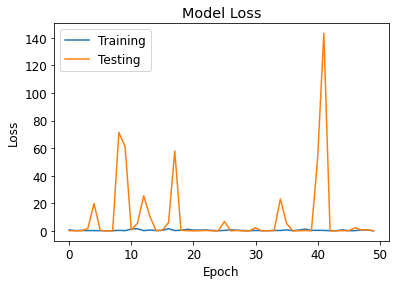

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()